# Starter code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math
#from tensorflow.keras.optimizers import Adam
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import GRU
#from keras.layers import ReLU
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error

#% matplotlib inline

#import plotly.offline as py
#import plotly.figure_factory as ff
#import plotly.graph_objs as go
from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;

#py.init_notebook_mode(connected=True)

#py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

#from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [2]:
#list_of_companies_number = ['1080']
#list_of_companies_number = ['13113']

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
len(list_of_companies_number)

99

In [4]:
help_time = []

In [5]:
#shape = [(nr of company, every possible timeslot from 8.01 till 16.30, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 
#data =  np.zeros(shape = (100, 5100,3)) 

In [6]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    five_best_bids_and_asks = np.zeros(shape = (2,2,5))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        five_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        five_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return five_best_bids_and_asks

In [7]:
def calc_semi_var(elements):
    mean = np.mean(elements)
    semi_var = 0
    for i in elements:
        if i<mean:
            semi_var += (mean-i)**2
    return semi_var

In [8]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [9]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [10]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [11]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [12]:
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [13]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute+1, 0
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [14]:
def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [15]:
def get_order_inbalance(record): #single company
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result

Reading data from files

In [16]:

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [17]:
# open file in read mode
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<=30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [18]:
# open file in read mode
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [19]:
data.shape
trades.shape

(99, 10)

# Plot of sweep to fill costs of company nr 1080 (Exhibit 1)

In [20]:
bid_and_ask_through_day = data[98][:510]

In [21]:
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
mid_prices = np.zeros(510)
true_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))

In [22]:
for i in range(510):
    mid_prices[i] = get_mid_price(bid_and_ask_through_day[i])
    true_prices[i] = get_true_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i][j] = get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j], true_prices[i])

Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000


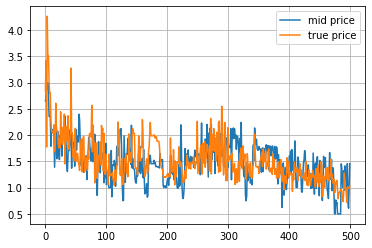

In [23]:
plt.plot(np.arange(500), average_fill_prices[10:,4]-mid_prices[10:])
plt.plot(np.arange(500), average_fill_prices[10:,4]-true_prices[10:])
plt.grid()
plt.legend(['mid price', 'true price'])

mid price


Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill

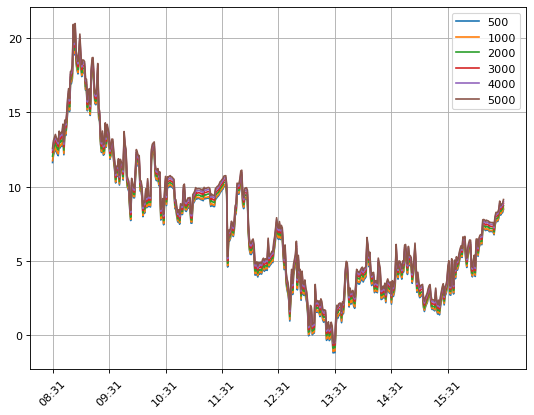

In [24]:
figure(figsize=(8, 6), dpi=80)
bid_and_ask_through_day = data[98]
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
mid_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))
for i in range(5100):
    mid_prices[i%510] += get_mid_price(bid_and_ask_through_day[i])
    curr_mid_price =  get_mid_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_mid_price)
for i in range(510):
    mid_prices[i]/=10
    average_fill_prices[i]/=10
#print(average_fill_prices[:,0])
mid_prices = apply_moving_average(np.copy(mid_prices), 5)
for i in range(6):
    average_fill_prices[:,i] = apply_moving_average(np.copy(average_fill_prices[:,i]), 5)
#average_fill_prices = apply_moving_average(np.copy(average_fill_prices), 3)

plot_since=30
for i in np.arange(len(order_sizes)):
    plt.plot(np.arange(510-plot_since), average_fill_prices[plot_since:,i]-true_prices[plot_since:])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x+plot_since)) for x in np.arange(510-plot_since, step=60)])
plt.xticks(ticks=np.arange(510-plot_since, step=60), labels=x_axis, rotation=45)
plt.grid()
plt.legend( order_sizes)

true price

Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill

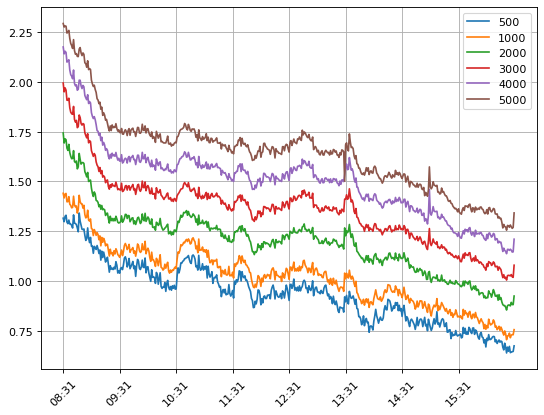

In [25]:
figure(figsize=(8, 6), dpi=80)
bid_and_ask_through_day = data[98]
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
true_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))
for i in range(5100):
    true_prices[i%510] += get_true_price(bid_and_ask_through_day[i])
    curr_true_price =  get_true_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_true_price)
for i in range(510):
    true_prices[i]/=10
    average_fill_prices[i]/=10
#print(average_fill_prices[:,0])
true_prices = apply_moving_average(np.copy(true_prices), 5)
for i in range(6):
    average_fill_prices[:,i] = apply_moving_average(np.copy(average_fill_prices[:,i]), 5)
#average_fill_prices = apply_moving_average(np.copy(average_fill_prices), 3)

plot_since=30
for i in np.arange(len(order_sizes)):
    plt.plot(np.arange(510-plot_since), average_fill_prices[plot_since:,i]-true_prices[plot_since:])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x+plot_since)) for x in np.arange(510-plot_since, step=60)])
plt.xticks(ticks=np.arange(510-plot_since, step=60), labels=x_axis, rotation=45)
plt.grid()
plt.legend( order_sizes)

In [26]:
bid_and_ask_through_day[0]

array([[[1582., 1580., 1579., 1576., 1575.],
        [1377.,  500., 1044., 8009.,  766.]],

       [[1588., 1589., 1591., 1592., 1596.],
        [1149.,   53., 1036.,  500., 4222.]]])

In [27]:
order_inbalance_one_day=get_order_inbalance(data[0][:510])

Plotting Bid, ask and true market prices(exhibit 6)

In [28]:
mid_price_one_day=np.zeros(510)
true_price_one_day=np.zeros(510)

for i in range (0,510):
    mid_price_one_day[i]=get_mid_price(data[0][i])
    true_price_one_day[i]=get_true_price(data[0][i])

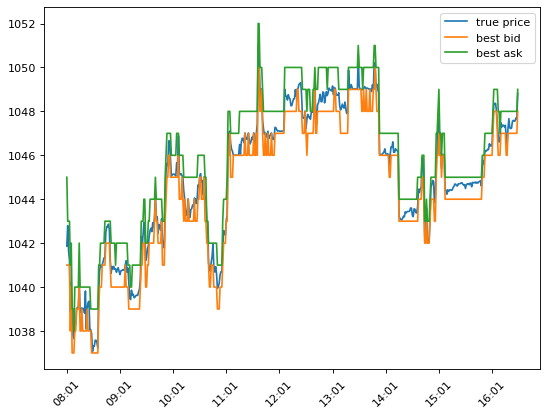

In [29]:
figure(figsize=(8, 6), dpi=80)

#plt.plot(np.arange(510), order_inbalance_one_day)#, mid_price_one_day)

#plt.plot(np.arange(510),  mid_price_one_day)
plt.plot(np.arange(510),  true_price_one_day)
plt.plot(np.arange(510),  data[0,:510,0,0,0])
plt.plot(np.arange(510),  data[0,:510,1,0,0])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x)) for x in np.arange(510, step=60)])
plt.xticks(ticks=np.arange(510, step=60), labels=x_axis, rotation=45)
plt.legend(['true price', 'best bid', 'best ask'])

Plotting Sweep to Fill Costs vs Order Size (exhibit 8 and 9)?????

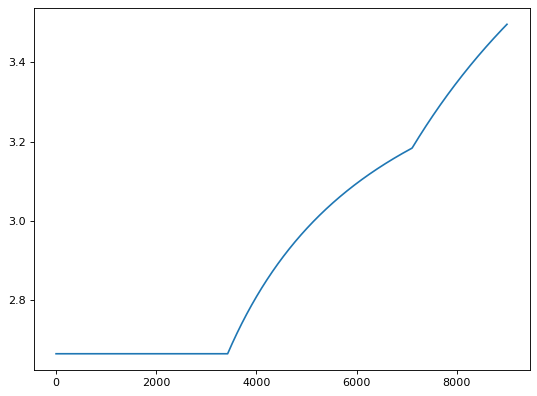

In [30]:
figure(figsize=(8, 6), dpi=80)
#bid_and_ask_through_first_two_hours = data[80][:120]
order_sizes_limit = 9000
true_price = get_true_price(data[80][40])
average_fill_prices = np.zeros(shape = (order_sizes_limit))
for i in range(1,order_sizes_limit+1):
    average_fill_prices[i-1] = get_sweep_to_fill_price(data[80][40], i,true_price)
plt.plot(average_fill_prices-true_price)

In [31]:
data[80][40]

array([[[1640., 1639., 1638., 1637., 1636.],
        [1715., 5727., 2576., 2830., 5163.]],

       [[1644., 1645., 1646., 1647., 1648.],
        [3425., 3681., 4334., 2581., 4997.]]])

In [32]:
order_inbalance_10_days=get_order_inbalance(data[1])
mid_price_10_days=[get_mid_price(data[1][i]) for i in range (0, 5100)]

In [33]:
company=90
order_inbalance_10_days=[round(i, 1) for i in get_order_inbalance(data[company])]
mid_price_10_days=np.asarray([get_mid_price(data[company][i]) for i in range (5100)])
price_diff=mid_price_10_days[:5099]-mid_price_10_days[1:]
inbalance_averageprice={}
for i in range(len(price_diff)):
    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    else:
        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
for k in inbalance_averageprice.keys():
    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

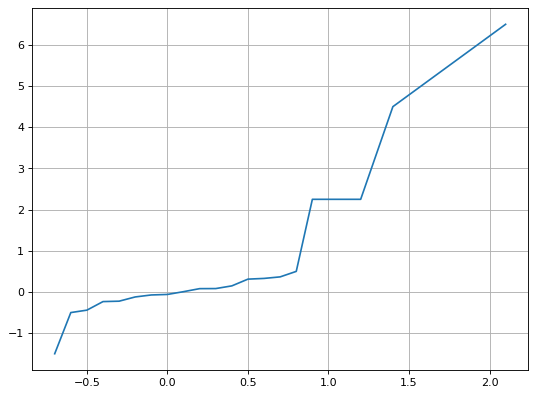

In [34]:
inbalance_averageprice_array=np.sort( np.asarray([[k, v] for k,v in inbalance_averageprice.items()]), axis=0)
figure(figsize=(8, 6), dpi=80)

plt.plot(inbalance_averageprice_array[5:,0], inbalance_averageprice_array[5:,1])

plt.grid()

In [35]:
inbalance_averageprice_array.shape

(25, 2)

Exhibit 17 -> Market impact for E-mini S&P Futures on a Typical Day (how to calculate true price after market impact???)

Unable to fill an order 5000
Unable to fill an order 2500
Unable to fill an order 5000
Unable to fill an order 5000


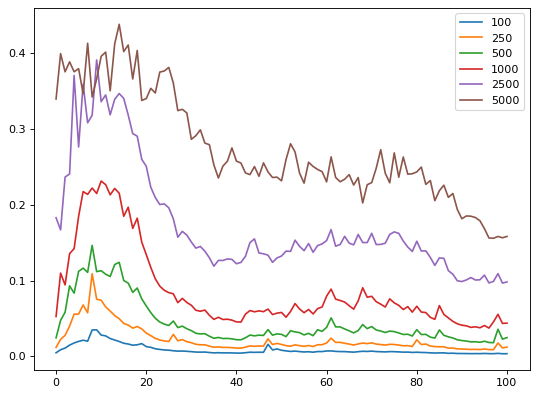

In [36]:
company_id = 15
order_sizes = [100, 250, 500, 1000, 2500, 5000]
num_of_timestamps = int((5100/5)-1)
modulo = int(510/5-1)
differences_in_prices = np.zeros(shape = (modulo, 6))
for i in range(num_of_timestamps):
    for order_size_ind in range(len(order_sizes)):
        price_before = get_true_price(np.copy(data[company_id][i*5]))
        price_after = get_true_price_after_sweep_to_fill(np.copy(data[company_id][i*5]), order_sizes[order_size_ind], price_before)
        differences_in_prices[i%modulo][order_size_ind] += abs(price_after - price_before)
figure(figsize=(8, 6), dpi=80)
for i in range(modulo):
    differences_in_prices[i]/=10
for k in range(len(order_sizes)):
    plt.plot(np.arange(modulo), apply_moving_average(np.copy(differences_in_prices[:,k]), 3))
plt.legend( order_sizes)
    

# Exhibit 3&4


In [37]:
comp_id=1
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
order_inbalance_comp=np.empty(shape=order_book_comp.shape[:2])
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]
    order_inbalance_comp[i]=get_order_inbalance(order_book_comp[i])

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time
time_to_next_trade=np.empty(shape=order_inbalance_comp.shape)

In [38]:
time_to_next_trade.shape

(10, 510)

In [39]:
trades[0].shape

(10,)

In [40]:
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        #print("XD", book_counter)
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        trade_time_tuple=trades_time_comp[day][trade_counter][2]
        time_to_next_trade[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
        # time to next trade given in seconds


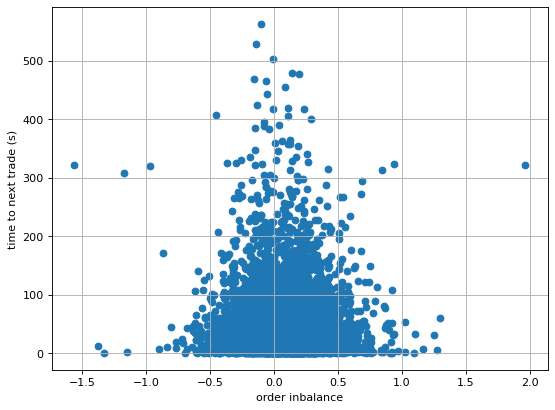

In [41]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='order inbalance', ylabel='time to next trade (s)')
plt.scatter(order_inbalance_comp.flatten(), time_to_next_trade.flatten())
plt.grid()
plt.show()

In [42]:
next_trades_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        next_trade_price=trades_time_comp[day][trade_counter][0]
        next_trades_prices[day, book_counter]=next_trade_price
        # time to next trade given in seconds

In [43]:
mid_market_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(order_book_comp.shape[0]):
    for record in range(order_book_comp.shape[1]):
        mid_market_prices[day, record]=get_mid_price(order_book_comp[day, record])

In [44]:
for day in range(mid_market_prices.shape[0]):
    for record in range(mid_market_prices.shape[1]):
        if mid_market_prices[day,record]==0:
            print(day, record)

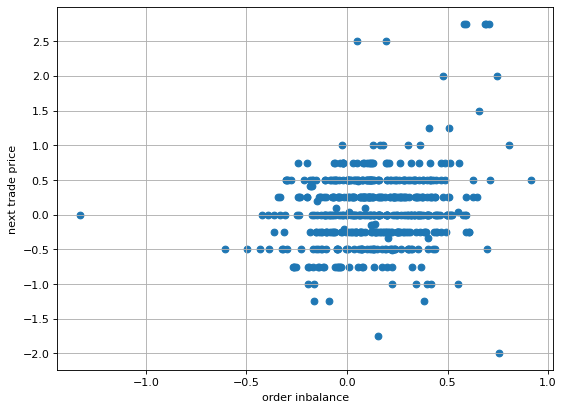

In [45]:
figure(figsize=(8, 6), dpi=80)
day=5
plt.axes(xlabel='order inbalance', ylabel='next trade price')
plt.scatter(order_inbalance_comp[day].flatten(), (next_trades_prices-mid_market_prices)[day].flatten())
max_next_trade_price=max((next_trades_prices-mid_market_prices)[day].flatten())
min_next_trade_price=min((next_trades_prices-mid_market_prices)[day].flatten())
plt.yticks(ticks=np.arange(start=min_next_trade_price, stop=max_next_trade_price, step=0.5))
plt.grid()
plt.show()

# Exhibit 11&12


In [46]:
interval=1
comp_id=3
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time

timestamps=510//interval
# buys on even, sells on odd
vwaps=np.zeros(shape=(10,2*timestamps)) 
order_sizes=np.zeros(shape=(10,2*timestamps))
#vwaps_sells=np.zeros(shape=(10,timestamps))
#order_sizes_sells=np.zeros(shape=(10,timestamps))



In [47]:
empty_orders=0
for day in range(vwaps.shape[0]):
    trade_counter=0
    for counter in range(vwaps.shape[1]//2):
        true_price=get_true_price(order_book_comp[day,counter])
        time_tuple=index_to_time(interval*(counter+1))
        buys=[]
        sells=[]
        buys_weights=[]
        sells_weights=[]
        while time_tuple>trades_time_comp[day][trade_counter][2]:
            if true_price<trades_time_comp[day][trade_counter][0]:
                buys.append(trades_time_comp[day][trade_counter][0])
                buys_weights.append(trades_time_comp[day][trade_counter][1])
            else:
                sells.append(trades_time_comp[day][trade_counter][0])
                sells_weights.append(trades_time_comp[day][trade_counter][1])               
            trade_counter+=1
            
        # in case there were no sells or buys during the interval            
        try:
            buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
        except:
            buys_avg=true_price
            buys_vol=0
            empty_orders+=1
        try:
            sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
        except:
            sells_avg=true_price
            sells_vol=0
            empty_orders+=1
        if sells_vol>10000 or buys_vol>10000:
            continue 
        vwaps[day,2*counter]=buys_avg-true_price
        vwaps[day,2*counter +1]=true_price-sells_avg
        order_sizes[day,2*counter]=buys_vol
        order_sizes[day,2*counter +1]=sells_vol
print('{}% of intervals were empty'.format(100*empty_orders/(10*2*timestamps)))

64.42156862745098% of intervals were empty


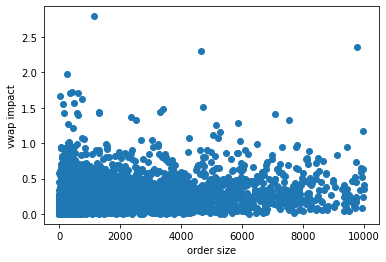

In [48]:
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes.flatten(), vwaps.flatten())

In [49]:
stacked_vwaps_sizes=np.stack((vwaps.flatten(), order_sizes.flatten()), axis=-1)
stacked_vwaps_sizes=np.sort(stacked_vwaps_sizes, axis=0)
#np.unique(stacked_vwaps_sizes, return_counts=True)

In [50]:
np.sort(np.array([[1,2],[1,4],[1,3]]), axis=0)

array([[1, 2],
       [1, 3],
       [1, 4]])

In [51]:
stacked_vwaps_sizes=np.stack((vwaps.flatten(), order_sizes.flatten()), axis=-1)
stacked_vwaps_sizes=np.sort(stacked_vwaps_sizes, axis=0)
#for x in  stacked_vwaps_sizes:#[:,0]
 #   if x[0]:
  #      print(x)

In [52]:
np.unique(order_sizes, return_counts=True)[1][0]

7060

In [53]:
np.unique(vwaps, return_counts=True)[1][0]

7060

In [54]:
vwaps[0].shape

(1020,)

**Exhibit 15 & 16**

In [55]:
company_id = 0
how_many_days = trades[company_id].shape[0]
num_of_five_min_buck = (7*60+2*30)//5
trading_volume_in_buckets = np.zeros(num_of_five_min_buck)
open_hour = 8
open_min = 30
end_hour = 16
end_min = 30
min_prices_in_buckets = np.ones(num_of_five_min_buck) * 10000000.0
max_prices_in_buckets = np.zeros(num_of_five_min_buck)

In [56]:
for i in range(10): #for every day
    for trade in trades[company_id][i]:
        trade_time = trade[2]
        trade_hour = trade_time[0]
        trade_min = trade_time[1]
        if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
            #print(trade)
            #print(trade_hour<open_hour)
            #print(trade_hour==open_hour and trade_min<open_min)
            #print(trade_hour==end_hour and trade_min>end_min)
            #print(trade_hour)
            #print(end_hour)
            #print(trade_hour>end_hour)
            continue
        which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//5
        min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
        max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
        trading_volume_in_buckets[which_bucket] += trade[1]
trading_volume_in_buckets/=10 #we take average of all days

In [57]:
price_volatility_in_buckets = max_prices_in_buckets - min_prices_in_buckets

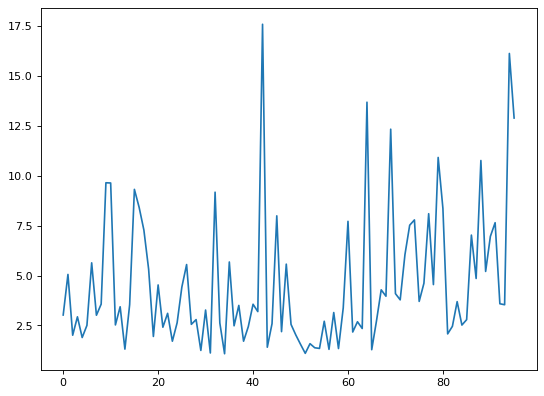

In [58]:
figure(figsize=(8, 6), dpi=80)

plt.plot(trading_volume_in_buckets/1000)

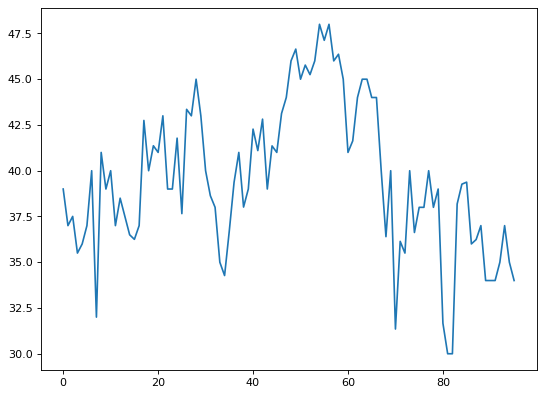

In [59]:
figure(figsize=(8, 6), dpi=80)
plt.plot(price_volatility_in_buckets)

# plot ORDER_IMPACT & VWAP


In [60]:
def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]
    result=np.zeros(timestamps//interval)
    for i in range (0,timestamps//interval):
        for j in range(interval):
            result[i]+=math.log((1e-10+np.sum(record[i+j][0][1]))/(1e-10+np.sum(record[i+j][1][1]))) # ln(bid size/ask size)
    return result

In [61]:
def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [62]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(vwaps.shape[0]):
        trade_counter=0
        for counter in range(vwaps.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(interval*(counter+1))
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
                sells_vol=math.nan
            if buys_vol>max_vol:
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return vwaps, order_sizes

In [63]:
np.average(np.arange(start=0, stop=11), weights=np.arange(11), returned=True)

(7.0, 55.0)

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty


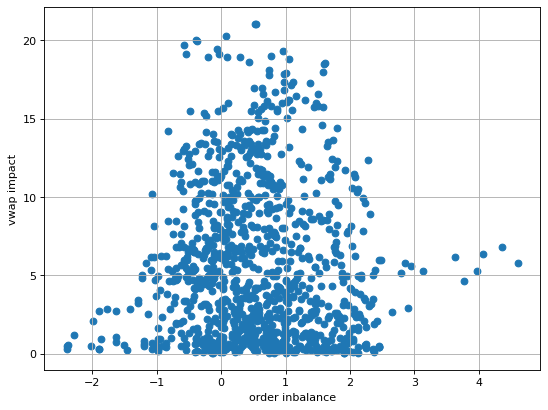

In [64]:
company=1
interval=5
time_to_skip=30
vwap, _=get_vwap_and_ordersizes_comp(company, interval, time_to_skip, use_abs=True)
order_inbalance=get_order_inbalance_comp(company, interval, time_to_skip)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='order inbalance', ylabel='vwap impact')
plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), vwap)
plt.grid()


In [65]:
order_inbalance.shape


(10, 96)

#  NEXTORDERX & S2FIMPACT

In [66]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(book_counter*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=np.abs(next_trade_price-true_price) #abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError
    return next_trade_x

In [67]:
order_book_comp=np.empty(shape=(10, 510-30, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[0, 510*i+30:510*(i+1)]
get_true_price(order_book_comp[1, 4])

1044.0542079729794

In [68]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [69]:
get_sweep_to_fill_price(data[0, 965], 40137, get_true_price(data[0, 965]), sweep_buys=False)

1051.0469392331265

In [70]:
get_true_price(data[0, 965])

1048.9780872414447

In [71]:
data[0, 965]

array([[[ 1048.,  1047.,  1046.,  1045.,  1044.],
        [ 9552., 16964., 14256.,  8836., 11223.]],

       [[ 1050.,  1051.,  1052.,  1053.,  1054.],
        [ 9980., 18293., 14908.,  7544., 12958.]]])

21.515151515151516% of intervals were SELL empty
27.828282828282827% of intervals were BUY empty
20.606060606060606% of intervals were SELL empty
26.565656565656564% of intervals were BUY empty


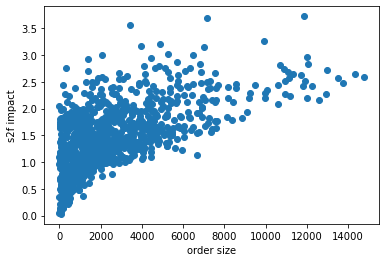

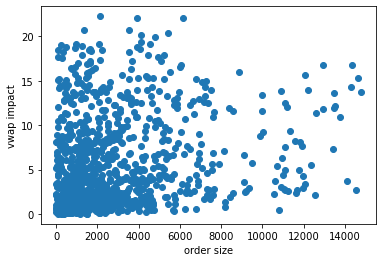

In [72]:
company_id=98
interval=5
time_to_skip=15

s2f_impacts, order_sizes_s2f=get_s2f_impact_and_ordersizes_comp(company_id, interval, time_to_skip,)
vwaps, order_sizes_vwaps=get_vwap_and_ordersizes_comp(company_id, interval, time_to_skip, max_vol=np.max(order_sizes_s2f.flatten()))

plt.axes(xlabel='order size', ylabel='s2f impact')
plt.scatter(order_sizes_s2f.flatten(), s2f_impacts.flatten())
plt.show()
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes_vwaps.flatten(), vwaps.flatten())
plt.show()

22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty


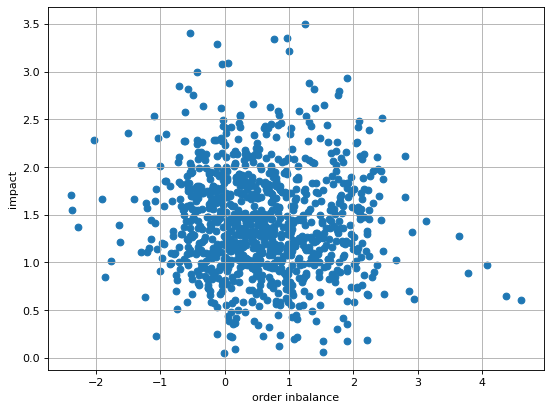

In [73]:
company=1
interval=5
time_to_skip=30
s2f_impacts, _=get_s2f_impact_and_ordersizes_comp(company_id, interval, time_to_skip,)
vwap, _=get_vwap_and_ordersizes_comp(company, interval, time_to_skip, use_abs=True)

order_inbalance=get_order_inbalance_comp(company, interval, time_to_skip)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='order inbalance', ylabel='impact')
plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), s2f_impacts)
#plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), vwap)
#plt.legend(['s2f', 'vwap'])
plt.grid()

# TRUE&MID PRICE


In [74]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp
def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [75]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [76]:
get_price_change_comp(interval=5, time_to_skip=30).shape

(10, 96)

In [77]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('zly shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

# HEATMAP

In [78]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,30,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [79]:
def get_trading_volume_and_price_volatility_bula(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (8*60+30-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    open_hour = 8
    open_min = 0
    end_hour = 16
    end_min = 30
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            trade_hour = trade_time[0]
            trade_min = trade_time[1]
            if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
                continue
            which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//interval
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [80]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
#trading_volumes_bula, price_volatilities_bula = get_trading_volume_and_price_volatility_bula(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
(10, 480)
(10, 480)
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


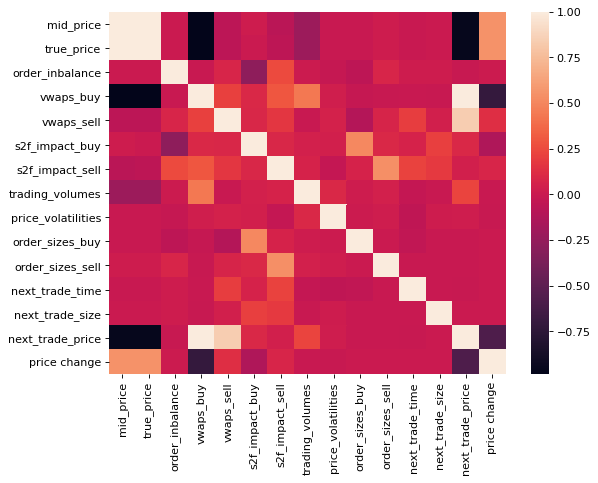

In [81]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='pearson'))
plt.show()

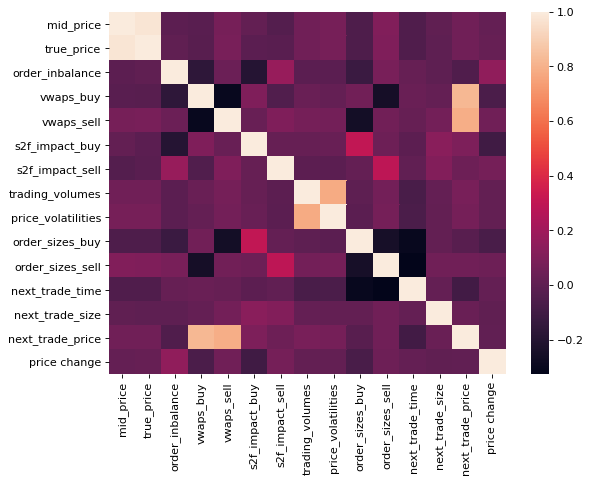

In [82]:
figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

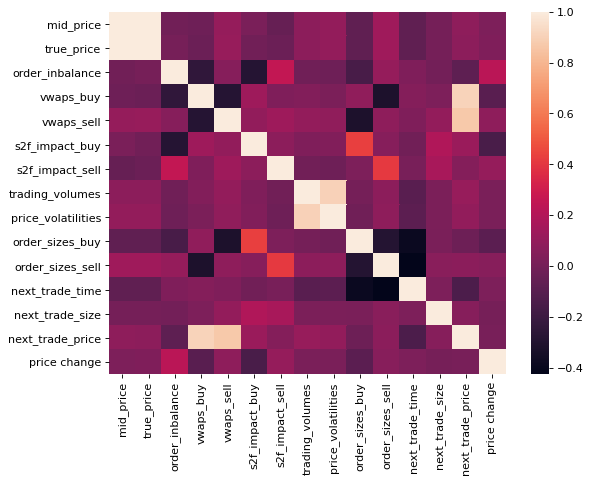

In [83]:
figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(df.corr(method='spearman'))
plt.show()

# LOGISTIC REGRESSION

In [84]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures


In [85]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
    rolled_records = np.roll(records, past, axis = 1)
    rolled_records = rolled_records[:,past:]
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            elements_in_past = np.copy(records[day][buck:buck+past])
            count_elem = 0.0
            sum_elem = 0.0
            for i in range(len(elements_in_past)):
                if math.isnan(elements_in_past[i]):
                    elements_in_past[i] = 0
                else:
                    sum_elem+=elements_in_past[i]
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [86]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
#trading_volumes_bula, price_volatilities_bula = get_trading_volume_and_price_volatility_bula(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
(10, 480)
(10, 480)
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


In [87]:
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [128]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = 1
            else:
                res[i][j]=0
    #print(true_prices)
    #print(res)
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=threshold: # price swing >= than threshold % of price
                res[i][j] = 1
            else:
                res[i][j]=0

    return res

In [129]:
xd = get_true_price_comp(1, 5, 0)
print(xd[0])
print("ELDOO")
print(get_y_to_test_max_bool(xd, 60, 5)[0])

[871.14150943 872.93830598 870.92605887 872.91324752 877.23645902
 874.80857143 873.97417707 874.77054292 878.47576887 878.16017316
 875.57692308 874.88997821 873.2161157  875.30665533 874.82089852
 872.84275921 873.16297705 872.64643603 868.86053535 870.49203242
 869.35277896 869.5461934  872.01084746 875.64476331 875.45639891
 877.         876.96293888 876.43243961 876.22871365 877.12225406
 879.17233951 879.43232803 881.19458128 882.66666667 883.90151422
 885.58878849 886.27205716 886.03702532 885.73020408 886.40322581
 887.41653393 886.77476099 887.14677327 889.81996086 891.33978426
 890.24414146 889.38216846 886.92837466 888.92041925 888.45641389
 887.36255124 883.48738812 885.97387844 884.80692704 885.24034458
 885.31997805 886.95688178 886.11451613 885.98539604 884.73603896
 884.88132198 886.45355462 886.35000958 885.84608281 885.67684943
 884.89856158 883.34119217 882.79942576 883.90439771 882.90832408
 882.18553271 881.00237756 883.0247619  882.85167702 882.78255971
 883.23674

# Testing predictions

In [130]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import confusion_matrix

In [118]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [162]:
def get_X_y_classic(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1,
                    period_of_getting_data_to_test = 60,
                    names=[], 
                    y_name='true_price',
                    test_min_max = 'max',
                    epsilon = 1e-7): # use up_and_down or not
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['vwaps_buy', 's2f_impact_buy']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_sell', 's2f_impact_sell']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name in ['vwaps_order_sizes_buy', 's2f_order_sizes_buy']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name == 'trading_volumes':
            arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'price_volatilities':
            _, arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    y = y[:,time_back:]
    print(y.flatten().shape)
    if test_min_max == 'max':
        y = get_y_to_test_max_bool(np.copy(y), period_of_getting_data_to_test, interval, epsilon)
    elif test_min_max == 'min':
        y = get_y_to_test_min_bool(np.copy(y), period_of_getting_data_to_test, interval, epslon)
    y = y.flatten()
    #print(y)
    return X, y

In [163]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [164]:
def test_logistic_regr_classic(X, y, split_percent, epsilon, 
                               use_scaling=False, 
                               local_names=names,
                               track_params=False):
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    print(X.shape)
    print(y.shape)
    print("SPLIT:", split)
    print(y[split:].shape)
    print(y_predicted.shape)
    print(X[split:].shape)
    print("Number of positive class in training dataset =", np.sum(y[:split]==1))
    print("Number of negative class in training dataset =", np.sum(y[:split]==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y[split:])/len(y_predicted))
    print("Confusion matrix:")
    print(confusion_matrix(y[split:], y_predicted))
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
(950,)

Epsilon =  0.0001
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.19791666666

21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3799041242909967
a   -0.7779896122636581
x   0.5034865083702084
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 19
Number of negative class in training dataset = 741
Percent of correc

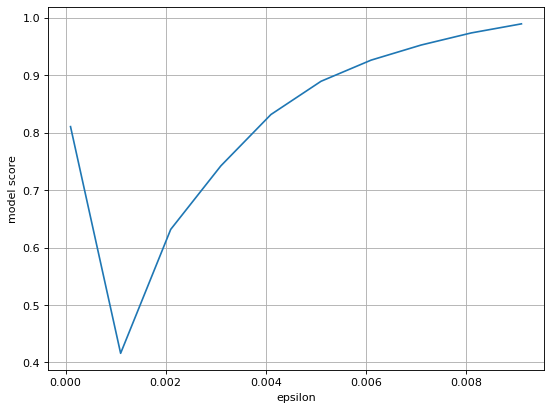

In [166]:
comp_id = 7
interval=5
time_to_skip=30
time_back=1
period_of_getting_data_to_test = 60
y_name='true_price'
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(0.0001,0.01, 0.001)
scores=[]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
print(y.shape)
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, epsilon)
    scores.append(test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, False, test_min_max))
#BEFORE SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

In [145]:
print(960-768)

192


22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)

Epsilon =  0.0
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147

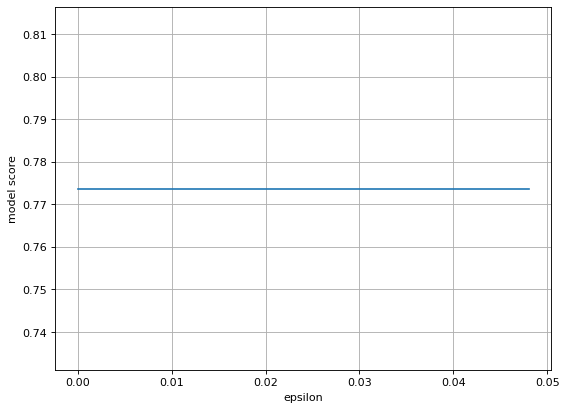

In [167]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
epsilons=np.arange(0.0,0.05, 0.002)
scores=[]
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, True, test_min_max))
#AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

# Find best epsilon

#### Testing max

In [ ]:
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 30
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(0.0,0.01, 0.001) #We define epsilons as percent of order of magnitude 
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [ ]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, check_change=True)
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=test_logistic_regr_classic(X, np.copy(y),split_percent, epsilons[eps], True,test_min_max, track_params=True)

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.title("Epsilon as percent of magnitude of stock price for checking rise of stocks")
plt.grid()

plt.plot(epsilons,np.sum(comp_eps, axis=0)/99)   ###NAJLEPIEJ DZIAŁA dla eps=0 ?????? ofc przy tych konkretnych parametrach interval, timeback itd

#### Testing min

In [140]:
test_min_max = 'min'
epsilons=np.arange(0.0,0.01, 0.001) #We define epsilons as percent of order of magnitude 
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, check_change=True)
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=test_logistic_regr_classic(X, np.copy(y),split_percent, epsilons[eps], True,test_min_max, track_params=True)

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
Number of positive class in training dataset = 108
Number of negative class in training dataset = 652
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   0]
 [ 32   0]]
Number of positive class in training dataset = 108
Number of nega

29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
Number of positive class in training dataset = 129
Number of negative class in training dataset = 631
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[162   0]
 [ 28   0]]
Number of positive class in training dataset = 129
Number of negative class in training dataset = 631
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[162   0]
 [ 28   0]]
Number of positive class in training dataset = 129
Number of negative class in training dataset = 631
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[162   0]
 [ 28   0]]
Number of positive class in training datase

Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of posit

Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
10
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333

25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[161   0]
 [ 29   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct cl

23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
Number of positive class in training dataset = 140
Number of negative class in training dataset = 620
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 140
Number of negative class in training dataset = 620
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 140
Number of negative class in training dataset = 620
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training

Number of positive class in training dataset = 178
Number of negative class in training dataset = 582
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 178
Number of negative class in training dataset = 582
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 178
Number of negative class in training dataset = 582
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 177
Number of negative class in training dataset = 583
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of posit

Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of posit

18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
Number of positive class in training dataset = 149
Number of negative class in training dataset = 611
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[145   0]
 [ 45   0]]
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.8210526315789474
Con

25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   0]
 [ 32   0]]
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   0]
 [ 32   0]]
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   0]
 [ 32   0]]
Number of positive class in training dataset = 131
Number of nega

Number of positive class in training dataset = 172
Number of negative class in training dataset = 588
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 171
Number of negative class in training dataset = 589
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 171
Number of negative class in training dataset = 589
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 170
Number of negative class in training dataset = 590
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[149   0]
 [ 41   0]]
Number of positive class in training dataset = 170
Number of negative class in training dataset = 590
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[149   0]
 [ 41   0]]
Number of posit

20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
Number of positive class in training dataset = 145
Number of negative class in training dataset = 615
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[141   0]
 [ 49   0]]
Number of positive class in

26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[142   0]
 [ 47   1]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[142   0]
 [ 47   1]]
Number of positive class in training dataset = 135
Number of negative class in training dataset = 625
Percent of correct classification:
0.7526

32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[157   0]
 [ 33   0]]
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[157   0]
 [ 33   0]]
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[157   0]
 [ 33   0]]
Number of positive class in training dataset = 131
Number of negati

Number of positive class in training dataset = 127
Number of negative class in training dataset = 633
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of positive class in training dataset = 127
Number of negative class in training dataset = 633
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of positive class in training dataset = 127
Number of negative class in training dataset = 633
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of positive class in training dataset = 126
Number of negative class in training dataset = 634
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of positive class in training dataset = 126
Number of negative class in training dataset = 634
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of posit

Number of positive class in training dataset = 137
Number of negative class in training dataset = 623
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 137
Number of negative class in training dataset = 623
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 137
Number of negative class in training dataset = 623
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
49
19.322916666

25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
Number of positive class in training dataset = 133
Number of negative class in training dataset = 627
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 133
Number of negati

22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
Number of positive class in training dataset = 149
Number of negative class in training dataset = 611
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   1]
 [ 31   0]]
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Number of positive class in training data

Number of positive class in training dataset = 133
Number of negative class in training dataset = 627
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[144   0]
 [ 46   0]]
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 546
Number of negative class

Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
62
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were 

Number of positive class in training dataset = 157
Number of negative class in training dataset = 603
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[155   0]
 [ 35   0]]
65
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
Number of positive class in training dataset = 131
Number of negativ

22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[154   0]
 [ 36   0]]
Number of positive class in training dataset = 136
Number of negati

25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
Number of positive class in training dataset = 129
Number of negative class in training dataset = 631
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[154   0]
 [ 36   0]]
Number of positive class in training dataset = 128
Number of negative class in training dataset = 632
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[154   0]
 [ 36   0]]
Number of positive class in training dataset = 127
Number of negative class in training dataset = 633
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[154   0]
 [ 36   0]]
Number of positive class in training datase

Number of positive class in training dataset = 139
Number of negative class in training dataset = 621
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   0]
 [ 50   0]]
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 583
Number of negative class

Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
78
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
2

14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
Number of positive class in training dataset = 171
Number of negative class in training dataset = 589
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[162   1]
 [ 27   0]]
Number of positive class in training dataset = 171
Number of negative class in training dataset = 589
Perce

32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
Number of positive class in training dataset = 139
Number of negative class in training dataset = 621
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[139   0]
 [ 51   0]]
Number of positive class in training dataset = 571
Number of negative class in training dataset = 189
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Number of positive class in training dataset = 571
Number of negative class in training dataset = 189
Percent of correct classification:
0.7842

39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
Number of positive class in training dataset = 114
Number of negative class in training dataset = 646
Percent of correct classification:
0.868421052631579
Confusion matrix:
[[165   0]
 [ 25   0]]
Number of positive class in training dataset = 114
Number of negative class in training dataset = 646
Percent of correct classification:
0.868421052631579
Confusion matrix:
[[165   0]
 [ 25   0]]
Number of positive class in training dataset = 114
Number of negative class in training dataset = 646
Percent of correct classification:
0.868421052631579
Confusion matrix:
[[165   0]
 [ 25   0]]
Number of positive class in training dataset = 114
Number of negative class in training dataset = 646
Percent of correct classification:
0.868421052631579
Confusion matrix:
[[165   0]
 [ 25   0]]
Number of positive class in training dataset =

Number of positive class in training dataset = 152
Number of negative class in training dataset = 608
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[140   0]
 [ 49   1]]
Number of positive class in training dataset = 596
Number of negative class in training dataset = 164
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Number of posit

Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
94
21.197916666

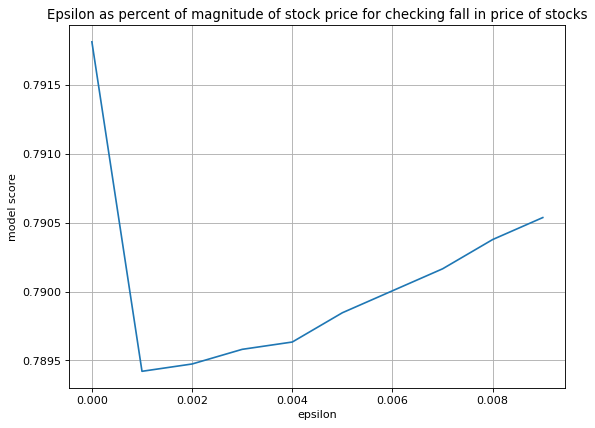

In [141]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.title("Epsilon as percent of magnitude of stock price for checking fall in price of stocks")
plt.grid()

plt.plot(epsilons,np.sum(comp_eps, axis=0)/99)   ###NAJLEPIEJ DZIAŁA dla eps=0 ?????? ofc przy tych konkretnych parametrach interval, timeback itd

# check most important features 

In [104]:
for k,v in param_dict_logreg.items():
    print(k, np.sum(np.abs(v))/len(v))

NameError: name 'param_dict' is not defined

# try with different features

In [201]:
comp_id = 90
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.005
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
Coefficient impact:
vwaps_buy   0.3550900085287161
vwaps_sell   0.19469958067881107
s2f_impact_buy   -0.04356744572719117
s2f_impact_sell   -0.0303910537237413
trading_volumes   0.028406975611134255
price_volatilities   0.10852520446209332
vwaps_order_sizes_buy   

20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
Coefficient impact:
vwaps_order_sizes_sell   0.22544260499859983
s2f_order_sizes_buy   0.060729884097398504
s2f_order_sizes_sell   -0.3643867592098314
next_trade_time   -0.2469568484833608
next_trade_size   -0.13884100782037956
next_trade_price   -0.35535885650700305
order_inbalance   -0.11932073751611014
vwaps_buy   0.3471924095244914
vwaps_sell   0.1579345551804775
s2f_impact_buy   -0.07414470359747985
s2f_impact_sell   0.042537755497634944
trading_vol

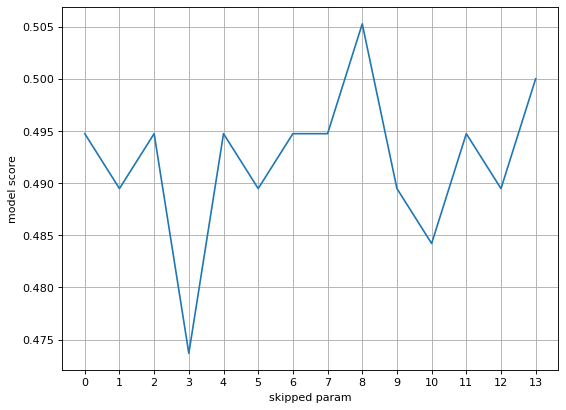

In [202]:

scores=[]
skipped_params=[]
names_len=len(names)
for i in range(names_len):
    name=names.pop(0)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    scores.append(test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, True, local_names=names))
    names.append(name)
    skipped_params.append(name)
    print('\nskipped ', name)
    #AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(ticks=np.arange(len(skipped_params)))
plt.grid()
plt.plot(scores)

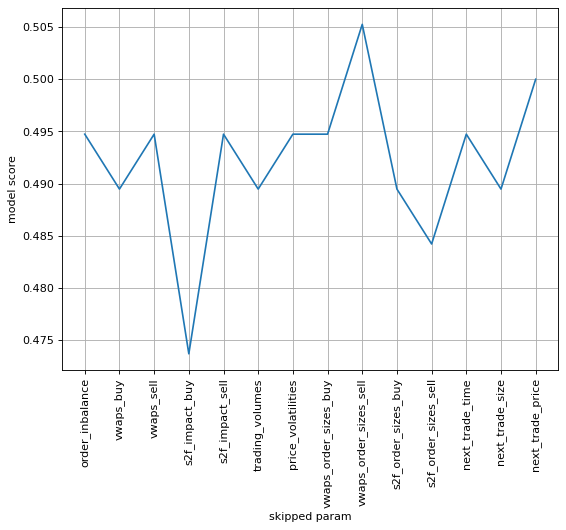

In [203]:
### FEATURE DROPPED ON X AXIS
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='vertical')
plt.grid()
plt.plot(scores)

# Decision trees classification

In [125]:
def test_decision_trees_classic(X, y, split_percent, epsilon, 
                               use_scaling=False, 
                               test_min_max = 'max'):
    if test_min_max == 'max':
        y=np.vectorize(test_high)(y,epsilon*y[0])#currently we hold price change in y
    elif test_min_max == 'min':
        y=np.vectorize(test_down)(y,epsilon*y[0])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier(random_state=0)).fit(X[:split], y[:split])
    else:
        clf = DecisionTreeClassifier(random_state=0).fit(X[:split], y[:split])
    y_predicted=clf.predict(X[split:])
    print("Number of positive class in training dataset =", np.sum(y[:split]==1))
    print("Number of negative class in training dataset =", np.sum(y[:split]==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y[split:])/len(y_predicted))
    print("Confusion matrix:")
    print(confusion_matrix(y[split:], y_predicted))
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty

Epsilon =  0.0
Number of positive class in training dataset = 155
Number of negative class in training dataset = 605
Percent of correct classification:
0.6473684210526316
Confusion matrix:
[[115  32]
 [ 35   8]]

Epsilon =  0.001
Number of positive class in training dataset = 155
Number of negative class in training dataset = 605
Percent of correct classifi

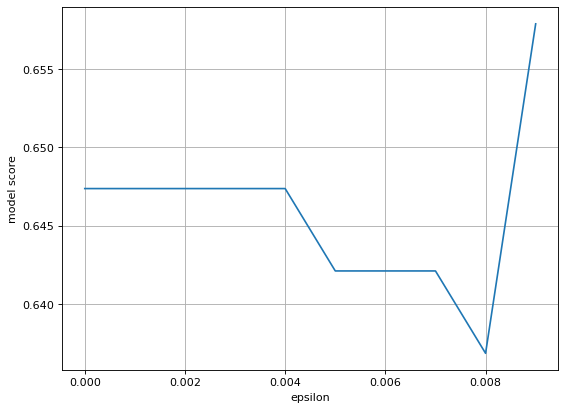

In [136]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
period_of_getting_data_to_test = 30
y_name='true_price'
test_min_max = 'min'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(0.0,0.01, 0.001)
scores=[]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_decision_trees_classic(X, np.copy(y),split_percent, epsilon, False, test_min_max))
#BEFORE SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

# XGBOOST

In [140]:
def test_xgb(X, y, split_percent, epsilon, use_scaling=False, check_up_down=True):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon)#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), xgb.XGBRegressor()).fit(X[:split], y[:split])
      #  print(clf.named_steps)
      #  print("Coefficient impact:")
      #  for i in range(len(names)):
      #      print(names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = xgb.XGBRegressor().fit(X[:split], y[:split])
      #  print("Coefficient impact:")
       # for i in range(len(names)):
        #    print(names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    print("mse: ", mse(y[split:], y_predicted))
    print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])    
  #  split=int(y.size*split_percent)
   # dtrain = xgb.DMatrix(X[:split], y[:split])
    #param=[]
    #num_round=10
    #bst = xgb.train(param, dtrain)
    #y_predicted=bst.predict(X[split:])
    


Epsilon =  0.0
mse:  1.3194455101776972
logistic regr score:  -0.33737598038563776

Epsilon =  0.005
mse:  1.2262100454868043
logistic regr score:  -0.25112864650726774

Epsilon =  0.01
mse:  1.2051373959312566
logistic regr score:  -0.25343455568061235

Epsilon =  0.015
mse:  1.1875336892273005
logistic regr score:  -0.24347273990908325

Epsilon =  0.02
mse:  1.120817342035193
logistic regr score:  -0.1970859777358127

Epsilon =  0.025
mse:  1.132312214606597
logistic regr score:  -0.20936304577805176

Epsilon =  0.03
mse:  1.1408901657546149
logistic regr score:  -0.23797333805469334

Epsilon =  0.035
mse:  1.1813637922182483
logistic regr score:  -0.28189103667314197

Epsilon =  0.04
mse:  1.069995572051883
logistic regr score:  -0.1690932249114101

Epsilon =  0.045
mse:  1.1049411553609687
logistic regr score:  -0.23569937139191377


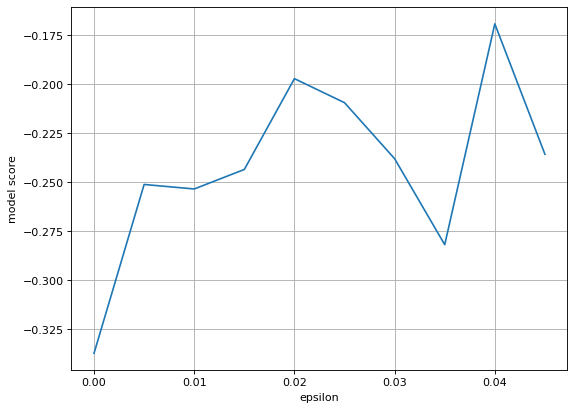

In [141]:
scores=[]
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_xgb(X, np.copy(y),split_percent, epsilon))
#AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)